# overfitting

## import libraries

In [1]:
import os
import json

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms.v2 as v2

from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from PIL import Image

import matplotlib.pyplot as plt


## Dataset

In [2]:
transforms = v2.ToPILImage()

dataset

In [3]:
MNIST_train = torchvision.datasets.MNIST('./data/mnist', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./data/mnist', download=True, train=False)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.58MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.30MB/s]


folders

In [4]:
if not os.path.exists('./dataset'):
  os.mkdir('./dataset')

  for info in ('train', 'test'):
    os.mkdir(os.path.join('./dataset', info))
    for i in range(10):
      os.mkdir(os.path.join('./dataset', info, f'class_{i}'))

In [5]:
for info in (('train', MNIST_train), ('test', MNIST_test)):
  for i in range(10):
    path = os.path.join('./dataset', info[0], f'class_{i}')
    cls = info[1].data[info[1].targets == i]
    for n, x in enumerate(cls):
      x = transforms(x)
      x.save(os.path.join(path, f'img_{n}.png'), 'png')

json file

In [6]:
targets = dict()
for i in range(10):
  targets[f'class_{i}'] = i

fp = open('/content/dataset/format.json', 'w')
json.dump(targets, fp)
fp.close()

## ImageFolder

In [7]:
to_tensor = v2.Compose([v2.ToTensor(), v2.Grayscale(),
                        v2.ToDtype(torch.float32, scale=True),
                        v2.Lambda(lambda x: x.ravel())])

d_train = ImageFolder('dataset/train', transform=to_tensor)
d_test = ImageFolder('dataset/test', transform=to_tensor)

/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


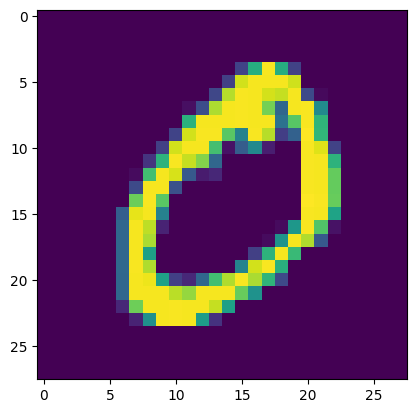

In [8]:
plt.imshow((d_train[0][0]*255).reshape(28, 28))

## Dataloader

In [9]:
d_train, d_val = data.random_split(d_train, [0.7, 0.3])

In [10]:
batch_size = 100

train_loader = data.DataLoader(d_train, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(d_val, batch_size=batch_size, shuffle=False)
test_loader = data.DataLoader(d_test, batch_size=batch_size, shuffle=False)

In [11]:
len(train_loader), len(d_train)

(420, 42000)

## Class NN

Dropout

In [12]:
class NN_mnist(nn.Module):
  def __init__(self, input_dim, num_hidden, output_dim):
    super().__init__()
    self.layer1 = nn.Linear(input_dim, num_hidden)
    self.layer2 = nn.Linear(num_hidden, output_dim)
    #self.dropout_1 = nn.Dropout(p=0.5)
    self.batch_norm_1 = nn.BatchNorm1d(num_hidden)

  def forward(self, x):
    x = self.layer1(x)
    x = nn.functional.relu(x)
    #x = self.dropout_1(x)
    x = self.batch_norm_1(x)
    x = self.layer2(x)

    return x

In [13]:
model = NN_mnist(28*28, 128, 10)

## Train

In [14]:
optimizer = optim.Adam(params=model.parameters(), lr=0.01)#, weight_decay=0.0001) # 0.001-0.00001
loss_f = nn.CrossEntropyLoss()

epochs= 20

In [15]:
loss_lst_val = []
loss_lst_train = []

In [16]:
from tqdm import tqdm

In [17]:
best_loss = 1e10

for epoch in range(epochs):
  model.train()
  loss_mean = 0
  lm_c = 0

  train_tqdm = tqdm(train_loader, leave=False)
  for x_train, y_train in train_tqdm:
    output = model(x_train)
    loss = loss_f(output, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lm_c += 1
    loss_mean = (1/lm_c)*loss.item() + (1 - 1/lm_c)*loss_mean

  model.eval()
  Q=0
  c = 0
  for x_val, y_val in val_loader:
    with torch.no_grad():
      output = model(x_val)
      loss = loss_f(output, y_val)
      Q += loss.item()
      c += 1
  Q /= c

  loss_lst_train.append(loss)
  loss_lst_val.append(Q)

  print(f' loss mean: {loss_mean:.3f}, Q_val: {Q:.3f}')

 loss mean: 0.228, Q_val: 0.153


 loss mean: 0.122, Q_val: 0.113


 loss mean: 0.088, Q_val: 0.120


 loss mean: 0.070, Q_val: 0.107


 loss mean: 0.060, Q_val: 0.115


 loss mean: 0.051, Q_val: 0.112


 loss mean: 0.046, Q_val: 0.120


 loss mean: 0.041, Q_val: 0.121


 loss mean: 0.036, Q_val: 0.127


 loss mean: 0.034, Q_val: 0.117


 loss mean: 0.037, Q_val: 0.127


 loss mean: 0.027, Q_val: 0.128


 loss mean: 0.025, Q_val: 0.134


 loss mean: 0.023, Q_val: 0.126


 loss mean: 0.025, Q_val: 0.150


 loss mean: 0.032, Q_val: 0.139


 loss mean: 0.026, Q_val: 0.155


 loss mean: 0.023, Q_val: 0.136


 loss mean: 0.018, Q_val: 0.155


 loss mean: 0.023, Q_val: 0.142


## Plot overfitting

Plot training and validation losses over epochs.

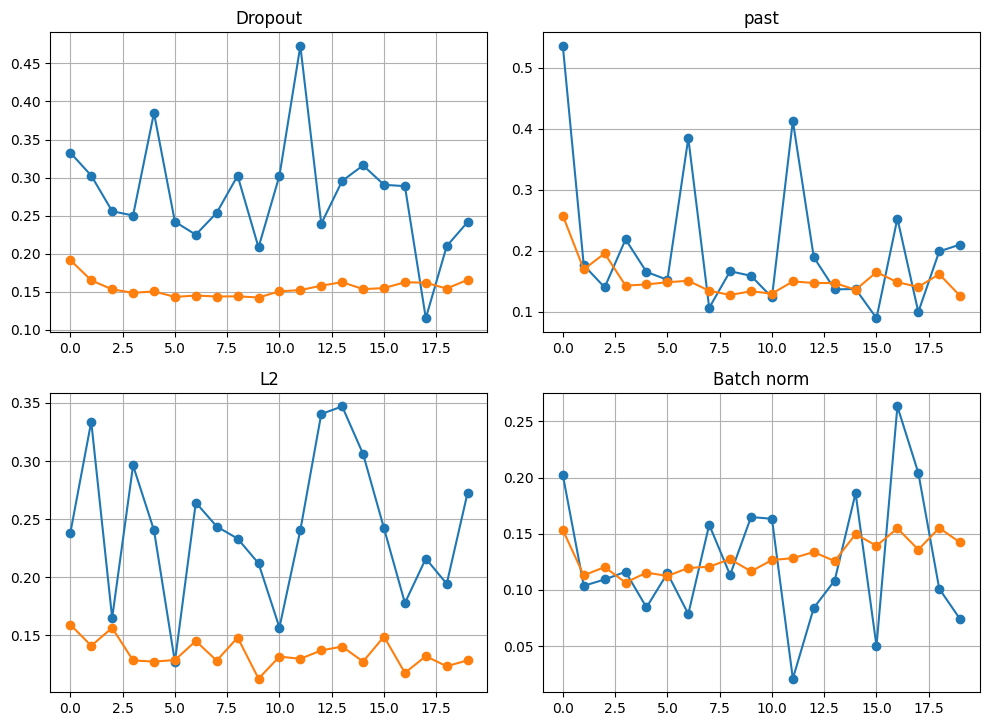

In [18]:
data1train = [0.3327,0.3026,0.2558,0.2501,0.3850,0.2420,0.2249,0.2537,0.3024,0.2082, 0.3024,0.4730,0.2393,0.2956,0.3160,0.2905,0.2887,0.1152,0.2099,0.2416]
data1val = [0.19156, 0.16493, 0.15308, 0.1485, 0.15035, 0.14315, 0.14495, 0.14366, 0.14395, 0.14235, 0.15047, 0.15213, 0.1579, 0.16254, 0.15334, 0.15474, 0.1624, 0.1618, 0.15412, 0.16562]

data2train = [0.5359, 0.1762, 0.1397, 0.2185,0.1651,0.1521,0.3846,0.1062,0.1662,0.1587,0.1233,0.4130,0.1893,0.1364,0.1371,0.0892,0.2527,0.0993,0.1988,0.2100]
data2val = [0.2575, 0.16934, 0.1954, 0.14264,0.14455,0.14817,0.15053,0.1342,0.12727, 0.13337,0.12943,0.1495,0.1469,0.1469,0.13585,0.16467,0.14822,0.14045, 0.1614,0.1257]

data3train = [0.2382,0.3339,0.1650,0.2962,0.2405,0.1274,0.2643,0.2437,0.2333,0.2120,0.1568,0.2406,0.3405,0.3470,0.3061,0.2422,0.1779,0.2161,0.1944,0.2729]
data3val = [0.1593,0.1411,0.1565,0.1285,0.1275,0.1288,0.1452,0.1283,0.1482,0.1128,0.1318,0.1299,0.1371,0.1404,0.1275,0.1490,0.1178,0.1321,0.1235,0.1286]

data4train = loss_lst_train
data4val = loss_lst_val


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Dropout
axes[0, 0].plot(data1train, marker='o')
axes[0, 0].plot(data1val, marker='o')
axes[0, 0].set_title('Dropout')
axes[0, 0].grid(True)

# past
axes[0, 1].plot(data2train, marker='o')
axes[0, 1].plot(data2val, marker='o')
axes[0, 1].set_title('past')
axes[0, 1].grid(axis='y')

# L2
axes[1, 0].plot(data3train, marker='o')
axes[1, 0].plot(data3val, marker='o')
axes[1, 0].set_title('L2')
axes[1, 0].grid(True)

# Batch Norm 1d
axes[1, 1].plot(data4train, marker='o')
axes[1, 1].plot(data4val, marker='o')
axes[1, 1].set_title('Batch norm')
axes[1, 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()